In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from src.model import emb_model as Emb_model

# Initialize data and model

In [2]:
def load_data(path = "./data/preprocessed_train_data.csv", is_np=True):
    train_data = pd.read_csv(path)
    if not is_np:
        return train_data
    X = train_data.iloc[:,:-1]
    X = np.array(X)
    y = train_data["price"]
    y = np.array(y)
    return X, y

In [3]:
X_tree, y_tree = load_data('./data/preprocessed_tree_train_data.csv')
X, y = load_data("./data/preprocessed_train_data.csv")
df = pd.read_csv("./data/preprocessed_train_data.csv")
print(X_tree.shape, y_tree.shape)
print(X.shape, y.shape)
print(df.shape)

# same random_state as data split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=2021)

(16589, 16) (16589,)
(16589, 123) (16589,)
(16589, 124)


In [4]:
# train or load model

# baseline model
baseline_model = load_model("./models/baseline_model.h5")

# embedded model
emb_model = Emb_model()
emb_model.load_weights("./models/emb_model")

# random forest
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=2021)
rf_regressor.fit(X_tree_train, y_tree_train)

# gradient boost 
gb_regressor = GradientBoostingRegressor(n_estimators=200, random_state=2021)
gb_regressor.fit(X_tree_train, y_tree_train)

GradientBoostingRegressor(n_estimators=200, random_state=2021)

## RMSE in different test part

In [5]:
def rmse_in_different_test_part():
    # import data
    kfold = KFold(n_splits=5)
    bl_rmse = []
    eb_rmse = []
    rf_rmse = []
    gb_rmse = []
    ensemble_rmse = []


    for _, test in kfold.split(X_test, y_test):
        bl_predict = np.squeeze(baseline_model.predict(X_test[test]))
        bl_rmse.append(mean_squared_error(y_test[test], bl_predict, squared=False))
        
        eb_predict = np.squeeze(emb_model.predict(X_test[test]))
        eb_rmse.append(mean_squared_error(y_test[test], eb_predict, squared=False))

        rf_predict = rf_regressor.predict(X_tree_test[test])
        rf_rmse.append(mean_squared_error(y_tree_test[test], rf_predict, squared=False))

        gb_predict = gb_regressor.predict(X_tree_test[test])
        gb_rmse.append(mean_squared_error(y_tree_test[test], gb_predict, squared=False))

        ensemble_predict = 0.2 * gb_predict + 0.2 * rf_predict + 0.3 * bl_predict + 0.3 * eb_predict
        ensemble_rmse.append(mean_squared_error(y_test[test], ensemble_predict, squared=False))

    x = range(1, 6)
    plt.figure(figsize=(9,6))
    plt.plot(x, bl_rmse, c="r", label="BaselineModel_RMSE")
    plt.plot(x, eb_rmse, c="g", label="EmbeddedModel_RMSE")
    plt.plot(x, rf_rmse, c="y", label="RandomForest_RMSE")
    plt.plot(x, gb_rmse, c="b", label="GradientBoosting_RMSE")
    plt.plot(x, ensemble_rmse, c="black", label="ensemble_RMSE")
    
    plt.xlabel("Fold No.")
    plt.ylabel("RMSE")
    plt.xticks(np.arange(1, 6, 1), [f"Kfold {i}" for i in range(1, 6)])
    plt.legend()
    plt.show()


<IPython.core.display.Javascript object>


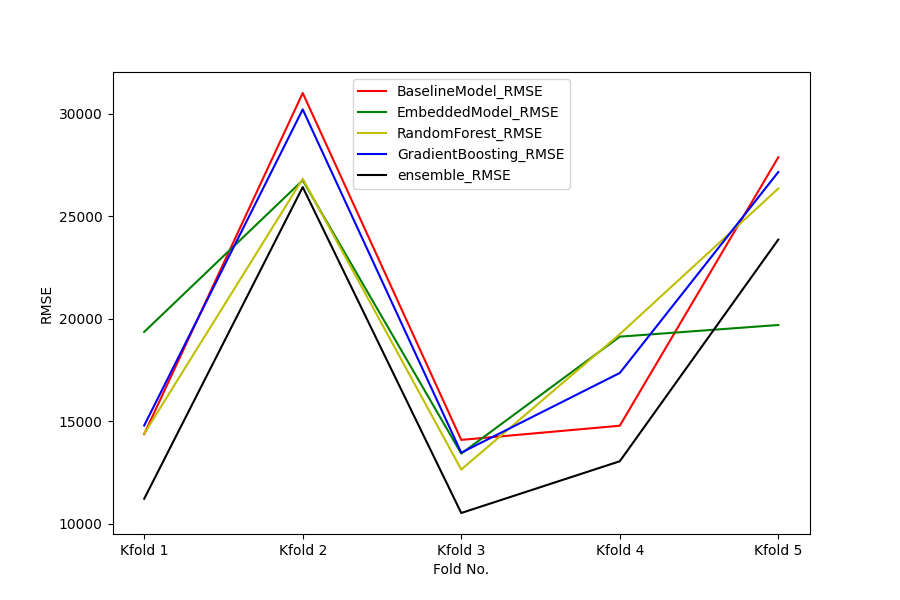

In [6]:
rmse_in_different_test_part()

## Price-Quantile

In [7]:
def price_quantile():
    df_y = [df.quantile(i*0.01).price for i in range(0, 101)]
    df_x = [(i)*0.01 for i in range(len(df_y))]
    quarter_y = [df.quantile(i*0.1).price for i in range(1,10)]
    quarter_x = [(i)*0.1 for i in range(1, 10)]

    plt.figure(figsize=(9,6))
#     plt.scatter(df_x, df_y)
    plt.plot(df_x, df_y)
    plt.scatter(quarter_x, quarter_y, c='r', label="Price with quantile{0.1,....0.9}")
    
    plt.xlabel("Quantile")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


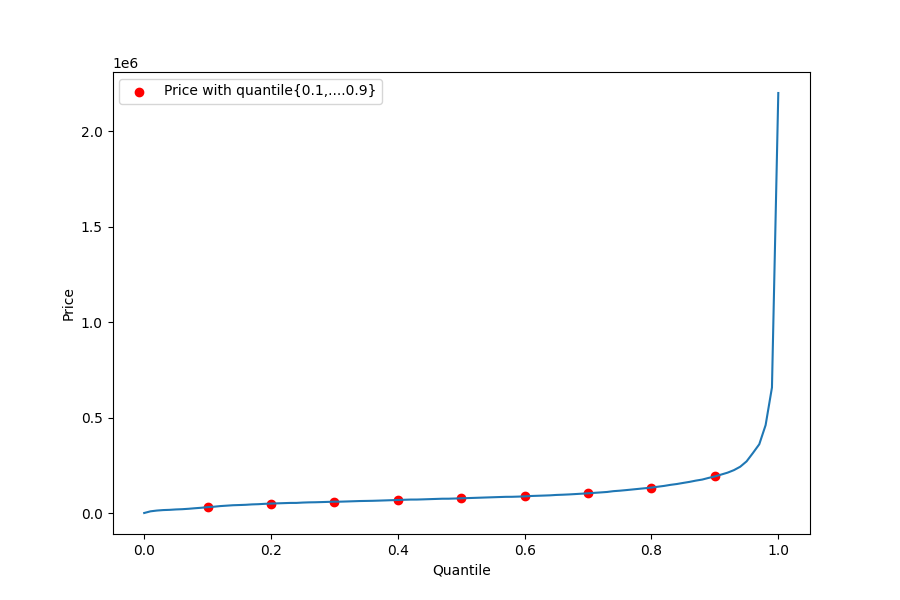

In [8]:
price_quantile()

## RMSE in different price range

In [12]:
# compute rmse in given price range
def rmse_in_one_price_range(left_quantile=0, right_quantile=1):
    xy_test = np.column_stack((X_test, y_test))
    xy_test_price = xy_test[df.quantile(left_quantile).price <= xy_test[:,-1]]
    xy_test_price = xy_test_price[xy_test_price[:,-1] < df.quantile(right_quantile).price]
    
    xy_tree_test = np.column_stack((X_tree_test, y_tree_test))
    xy_tree_test_price = xy_tree_test[df.quantile(left_quantile).price <= xy_tree_test[:,-1]]
    xy_tree_test_price = xy_tree_test_price[xy_tree_test_price[:,-1] < df.quantile(right_quantile).price]
    
    def compute_rmse(X, X_tree, y):
        bl_predict = np.squeeze(baseline_model.predict(X))
        bl_rmse = mean_squared_error(y, bl_predict, squared=False)

        eb_predict = np.squeeze(emb_model.predict(X))
        eb_rmse = mean_squared_error(y, eb_predict, squared=False)

        rf_predict = rf_regressor.predict(X_tree)
        rf_rmse = mean_squared_error(y, rf_predict, squared=False)

        gb_predict = gb_regressor.predict(X_tree)
        gb_rmse = mean_squared_error(y, gb_predict, squared=False)

        ensemble_predict = 0.2 * gb_predict + 0.2 * rf_predict + 0.3 * bl_predict + 0.3 * eb_predict
        ensemble_rmse = mean_squared_error(y, ensemble_predict, squared=False)
        
        return bl_rmse, eb_rmse, rf_rmse, gb_rmse, ensemble_rmse
    
    return compute_rmse(xy_test_price[:,:-1], xy_tree_test_price[:,:-1], xy_test_price[:,-1])

In [13]:
def rmse_in_different_price_range():
    bl_rmse_lst = []
    eb_rmse_lst = []
    rf_rmse_lst = []
    gb_rmse_lst = []
    ensemble_rmse_lst = []
    for i in range(10):
        bl_rmse, eb_rmse, rf_rmse, gb_rmse, ensemble_rmse = rmse_in_one_price_range(i*0.1, (i+1)*0.1)
        bl_rmse_lst.append(bl_rmse)
        eb_rmse_lst.append(eb_rmse)
        rf_rmse_lst.append(rf_rmse)
        gb_rmse_lst.append(gb_rmse)
        ensemble_rmse_lst.append(ensemble_rmse)
    x = [i*0.1 for i in range(10)]
    
    
    plt.figure(figsize=(9,6))
    plt.plot(x, bl_rmse_lst, c="r", label="BaselineModel_RMSE")
    plt.plot(x, bl_rmse_lst, c="g", label="EmbeddedModel_RMSE")
    plt.plot(x, rf_rmse_lst, c="y", label="RandomForest_RMSE")
    plt.plot(x, gb_rmse_lst, c="b", label="GradientBoosting_RMSE")
    plt.plot(x, ensemble_rmse_lst, c="black", label="ensemble_RMSE")
    
    plt.xlabel("Price Range(in quantile)")
    plt.ylabel("RMSE")
    
    plt.xticks(x, [f"[{round(i, 1)}, {round(i+0.1, 1)})" for i in x])
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


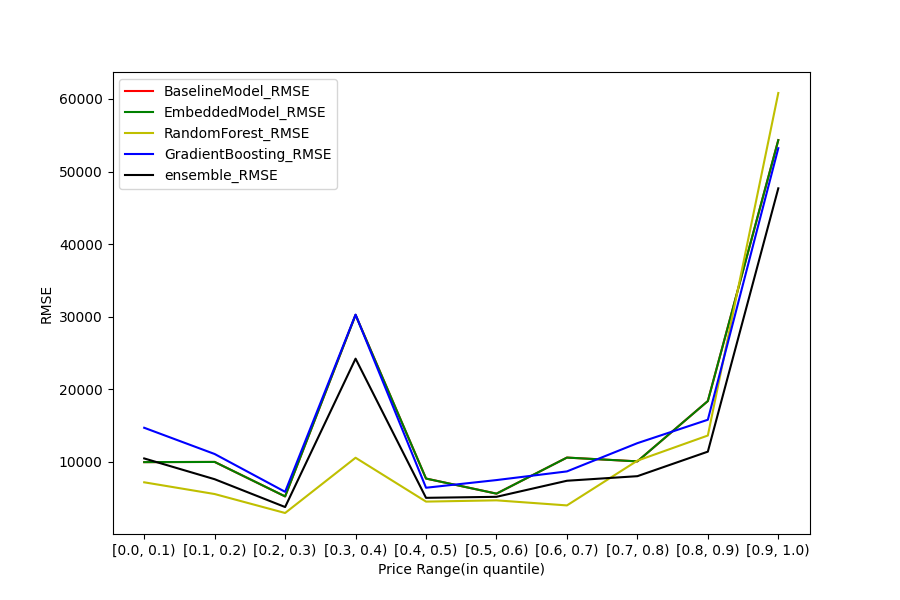

In [14]:
rmse_in_different_price_range()